## Advanced Lane Finding
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Camera Calibration

In [197]:
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import glob
import pickle
%matplotlib inline

camera_calibration_dir = os.path.join(os.getcwd(),"camera_cal")
print("Using Calibration files from Directory:\n ", camera_calibration_dir)

cal_images = glob.glob(os.path.join(camera_calibration_dir, "calibration*.jpg"))
print("Found {} calibration images.".format(len(cal_images)))


Using Calibration files from Directory:
  /home/ankur/UdacityND/CarND-Advanced-Lane-Lines/camera_cal
Found 20 calibration images.


In [115]:
def create_3D_obj_points(nx, ny):
    obj = np.zeros((nx*ny,3), np.float32)
    obj[:, 0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    return obj

In [149]:
def save_calibration(mtx, dist, pickle_name):#Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration = {}
    calibration["mtx"] = mtx
    calibration["dist"] = dist
    pickle.dump( calibration, open(pickle_name, "wb"))
    
def get_calibration(calib_name):
    calibration = pickle.load(open(calib_name, "rb"))
    return calibration

In [116]:
def get_image_corners(image_list, nx = 9, ny = 6, num_images = 20, debug=False):
    image_pts = []
    obj_pts = []
    for fname in cal_images[0:num_images]:
        debug_string = ''
        debug_string += "Image: " + fname + "\n"
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #plt.imshow(gray, cmap='gray')
        
        # Find the chessboard corners
        ret, img_corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        # If found, draw corners
        if ret:
            # Draw and display the corners
            #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            debug_string += ("# of corners found: {}\n".format(len(corners)))
            image_pts.append(img_corners)
            obj_pts.append(create_3D_obj_points(nx, ny))
            #plt.imshow(img)
        else:
            debug_string += ("No corners found\n")
            
        if debug:
            print(debug_string)
    return image_pts, obj_pts
        


In [117]:
#setup calibration details
nx,ny = 9,6
img = cv2.imread(cal_images[0])
img_size = (img.shape[1], img.shape[0])

#Get list of image points and correspondin 3D points
image_points, obj_points = get_image_corners(cal_images, nx, ny)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, image_points, img_size,None,None)

#Save calibration file as a pickle
calib_file_name = os.path.join(camera_calibration_dir,"calibration_pickle.p")
save_calibration(mtx, dist, calib_file_name)

In [130]:
# Test undistortion on images...save them to a folder for easy viewing
calibration_output_dir = os.path.join(camera_calibration_dir, "calib_output")

if not os.path.isdir(calibration_output_dir):
    os.mkdir(calibration_output_dir)
    
for fname in cal_images:
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    name = os.path.basename(fname)
    output_name = os.path.join(calibration_output_dir,name)
    vis_out = np.concatenate((img, dst_img), axis=1)
    ret = cv2.imwrite(output_name,vis_out)

In [142]:
calib_name = os.path.join(camera_calibration_dir,"calibration_pickle.p")
calibration = get_calibration(calib_name)

{'dist': array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]]), 'mtx': array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
       [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])}


In [147]:
test_dir = "/home/ankur/UdacityND/CarND-Advanced-Lane-Lines/test_images/"
for fname in glob.glob(os.path.join(test_dir, "*.jpg")):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    name = "out_" + os.path.basename(fname)
    print(name)
    output_name = os.path.join(test_dir,name)
    dst_img = cv2.undistort(img, mtx, dist, None, mtx)
    vis_out = np.concatenate((img, dst_img), axis=1)
    ret = cv2.imwrite(output_name,vis_out)

out_straight_lines1.jpg
out_test6.jpg
out_test2.jpg
out_test4.jpg
out_straight_lines2.jpg
out_test3.jpg
out_test5.jpg
out_test1.jpg


### Create a thresholded binary image.

* Undistort RGB image
* Select ROI ( 0<y<400 can be masked out, or mask out top 60% of image)
* Use different color channel and gradient thresh (Binary Image)
 * R, S and slopes of lines
* Apply Perspective Transform on Binary Image (this on color image won't give anything extra)
 * Start with P1 trapezoid. We can try to make it smarter later.
* Lane detection, sliding window

(1280, 738)


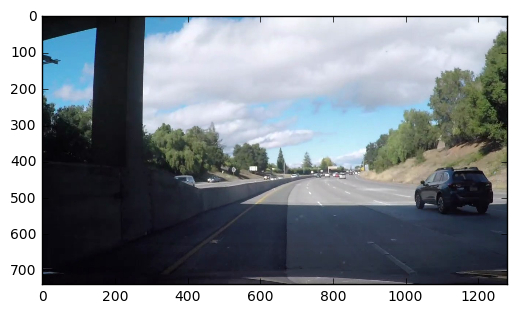

In [482]:
img = cv2.imread("test_images/challenge_5.jpg")
img_size = (img.shape[1], img.shape[0])
print(img_size)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [483]:
def create_horizontal_mask(img, y_limit):
    mask = np.ones_like(img)
    mask[0 : y_limit, :, :]=0
    return mask

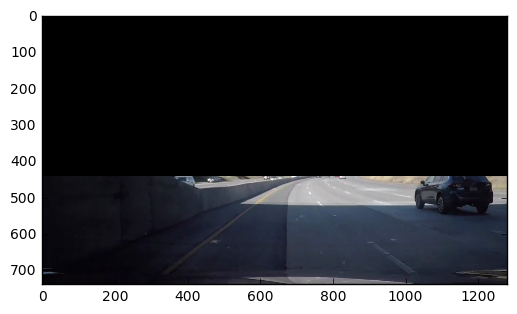

In [484]:
mask = create_horizontal_mask(img, y_limit=int(0.6*img.shape[0]))
masked_img = mask*img

plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

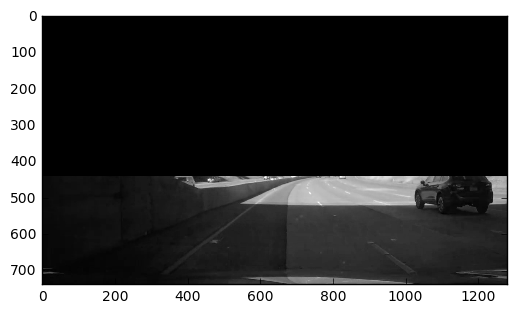

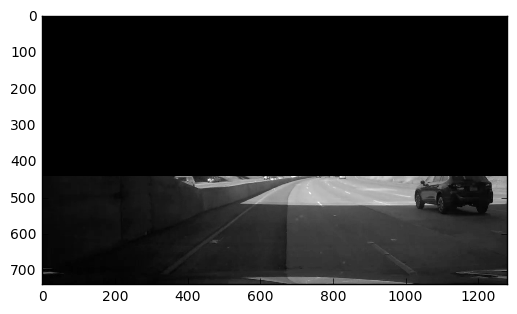

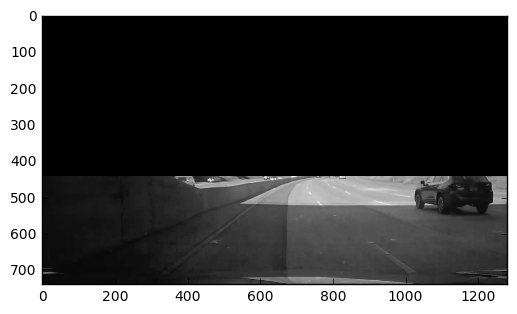

In [485]:
(b,g,r) = cv2.split(masked_img)
plt.imshow(r, cmap="gray")
plt.show()
plt.imshow(g, cmap="gray")
plt.show()
plt.imshow(b, cmap="gray")
plt.show()

342


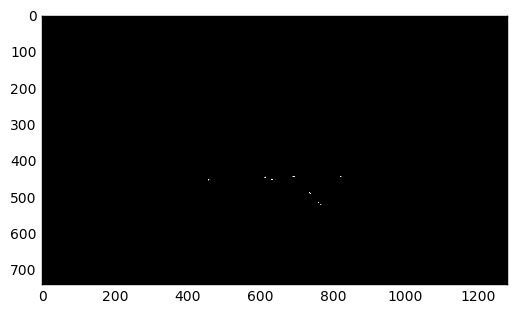

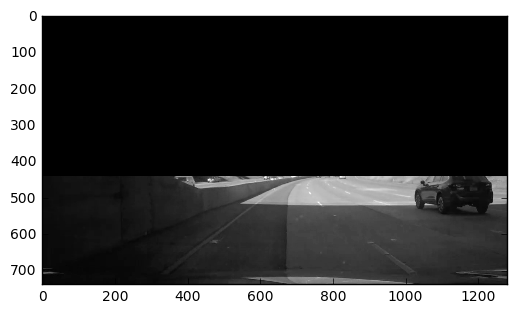

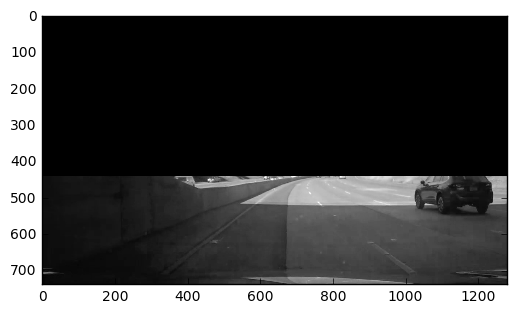

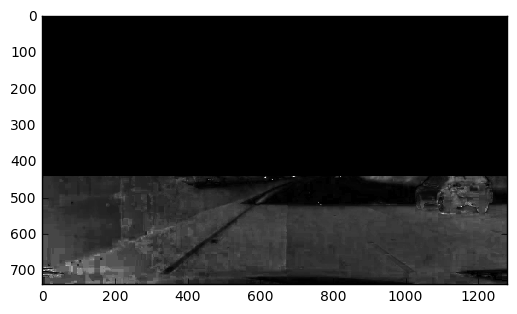

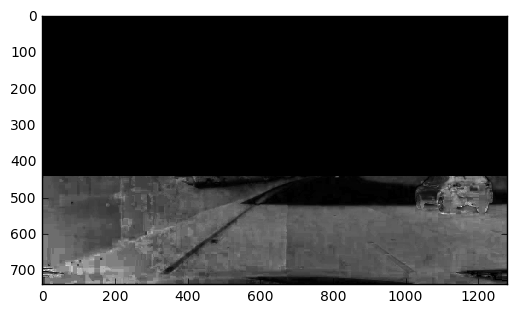

In [487]:
hls = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HLS)
h = hls[:, :, 0]
l = hls[:, :, 1]
s = hls[:, :, 2]
hsv = cv2.cvtColor(masked_img, cv2.COLOR_BGR2HSV)
h1 = hsv[:, :, 0]
s1 = hsv[:, :, 1]
v = hsv[:, :, 2]

t = np.zeros_like(masked_img)

#t[(v > 140), 0] = 255
#t[(v > 220)] = 255
#t[(v > 140)& (r > 180) | (s > 180)] = 255
t[(v > 240) | ((r > 240) & (g > 240)) | (s > 240)] = 255#| ((r > 180) & (g > 180)) | (s > 180)] = 255
t[(r < 85) & (g < 85)] = 0
print(np.count_nonzero(t))
#t[r > 180, 2] = 255
#t[(v > 180)&(s > 180)] = 255
#t[(r < ]
#l[(h < 31) & (h > 0)] = 255
#l[(s > 120)] = 255
#l = np.zeros_like(h)
plt.imshow(t, cmap="gray")
plt.show()

plt.imshow(l, cmap="gray")
plt.show()
plt.imshow(v, cmap="gray")
plt.show()

plt.imshow(s, cmap="gray")
plt.show()
plt.imshow(s1, cmap="gray")
plt.show()

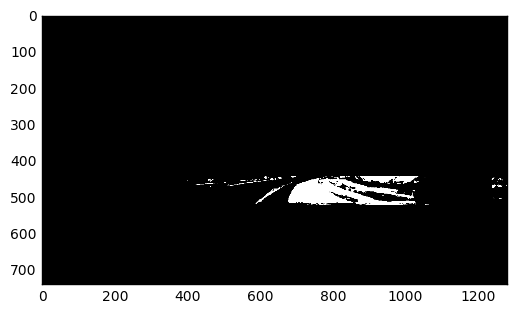

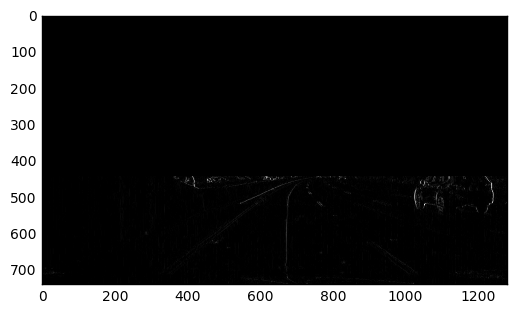

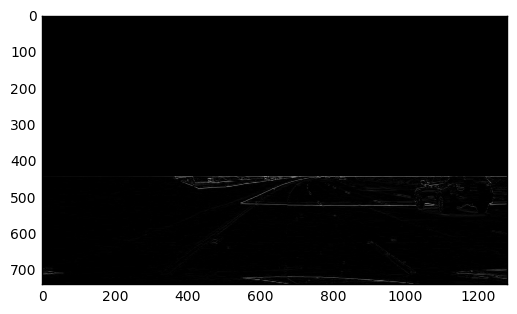

In [489]:
sx = np.absolute(cv2.Sobel(b, cv2.CV_64F, 1, 0))
sy = np.absolute(cv2.Sobel(b, cv2.CV_64F, 0, 1))
sx *= 255/np.max(sx) 
t[sx < 20] = 0
t[(v > 180) & (r > 180)] = 255
plt.imshow(t, cmap="gray")
plt.show()
plt.imshow(sx, cmap="gray")
plt.show()
plt.imshow(sy, cmap="gray")
plt.show()

0.0


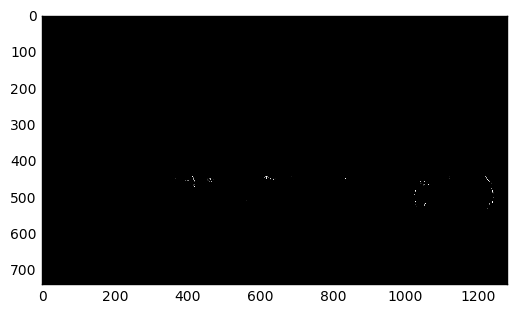

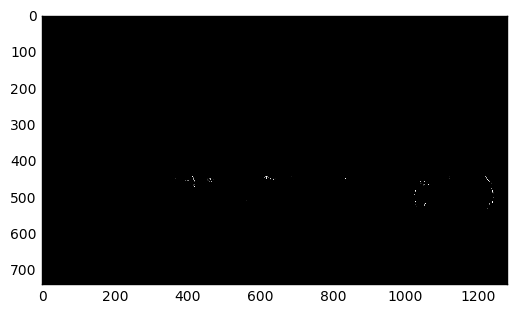

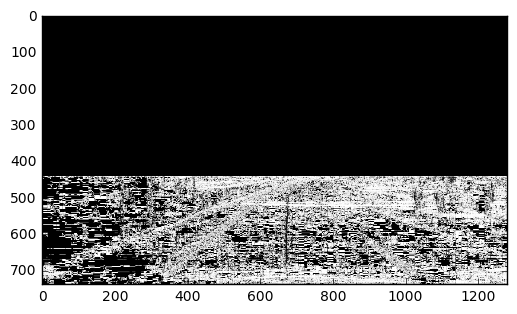

In [490]:
s = np.zeros_like(sx)
t = np.arctan2(sy, sx)
print(np.min(t))
s[(sx > 80) & (sy > 80)]=255
plt.imshow(s, cmap="gray")
plt.show()
#s[(t < 0.9) | (t > 1.2)]=0
plt.imshow(s, cmap="gray")
plt.show()
plt.imshow(t, cmap="gray")
plt.show()